In [4]:
import os
# Define dataset path
dataset_path = "geotiffs"

# Example: Disaster-specific folder
tier_folder = os.path.join(dataset_path, "tier1")
images_folder = os.path.join(tier_folder, "images")
labels_folder = os.path.join(tier_folder, "labels")


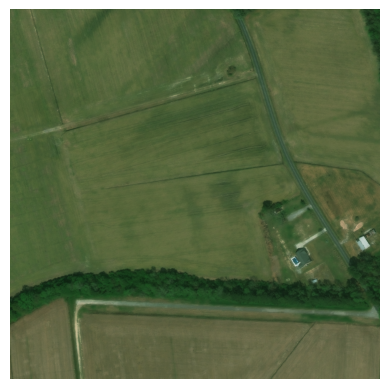

{
    "features": {
        "lng_lat": [
            {
                "properties": {
                    "feature_type": "building",
                    "uid": "8b78dbe3-d082-41e0-abf3-4c06eb99270d"
                },
                "wkt": "POLYGON ((-77.93974254710972 34.56770271107827, -77.93966091613942 34.56761075076842, -77.93972316340545 34.56757026726694, -77.93974702288374 34.56757039695101, -77.93977193996783 34.56755217738122, -77.93980544934283 34.56758614196894, -77.93980509609661 34.56759394338734, -77.93984146150181 34.56762787516347, -77.93983653286949 34.56763059159534, -77.93986715040529 34.56766330932185, -77.93981297535709 34.56770253005008, -77.93975550957526 34.56772165456024, -77.93974254710972 34.56770271107827))"
            },
            {
                "properties": {
                    "feature_type": "building",
                    "uid": "6abee917-faa1-4bd8-a82b-d7599f3f9ec9"
                },
                "wkt": "POLYGON ((-77.93964769167418 34.

In [6]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy
import json

imageID = "hurricane-florence_00000059_pre_disaster"

# Load a sample image
image_file = os.path.join(images_folder, f"{imageID}.tif")
image = tiff.imread(image_file)

# Display the image
plt.imshow(image)
plt.axis("off")
plt.show()

# Load label JSON file
label_file = os.path.join(labels_folder, f"{imageID}.json")
with open(label_file, "r") as f:
    label_data = json.load(f)

# Print label information
print(json.dumps(label_data, indent=4))


In [33]:
# Import necessary libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rasterio
from rasterio.plot import show
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [34]:
def load_data(dataset_path):
    """Load and prepare 10% of data for training, validation, and testing."""
    # Gather image paths
    tier1_images = glob.glob(os.path.join(dataset_path, 'tier1', 'images', '*.*'))
    tier3_images = glob.glob(os.path.join(dataset_path, 'tier3', 'images', '*.*'))
    all_images = tier1_images + tier3_images
    test_images_full = glob.glob(os.path.join(dataset_path, 'test', 'images', '*.*'))
    
    # Split for validation
    train_images_full, val_images = train_test_split(all_images, test_size=0.2, random_state=42)
    
    # Subsample 10% of training data
    train_images, _ = train_test_split(train_images_full, test_size=0.9, random_state=42)
    
    # Subsample 10% of test data
    test_images, _ = train_test_split(test_images_full, test_size=0.9, random_state=42)
    
    # Transforms remain the same as your original code
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Datasets and loaders
    train_dataset = DisasterDataset(train_images, transform=train_transform)
    val_dataset = DisasterDataset(val_images, transform=val_transform)
    test_dataset = DisasterDataset(test_images, transform=val_transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    return train_loader, val_loader, test_loader

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models

def create_model(num_classes=2, pretrained=True):
    """Create a pretrained ResNet model with custom classifier"""
    model = models.resnet18(pretrained=pretrained)
    
    # Freeze initial layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace final layers
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, num_classes)
    )
    return model

def train_model(train_loader, val_loader, model, device, num_epochs=25):
    """Train model with validation monitoring"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}\n')

        # Update learning rate
        scheduler.step()

        # Deep copy the best model
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [51]:
def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate the trained model on the test set."""
    model = model.to(device)
    model.eval()
    
    test_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            test_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = test_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {test_acc:.4f}')
    
    # Create a confusion matrix
    confusion = np.zeros((2, 2), dtype=np.int64)
    for p, l in zip(all_preds, all_labels):
        confusion[p, l] += 1
    
    print('Confusion Matrix:')
    print(confusion)
    
    return test_acc, confusion

In [52]:
def visualize_results(model, test_loader, device='cuda', num_images=5):
    """Visualize some test images with their predictions."""
    model = model.to(device)
    model.eval()
    
    classes = ['Pre-Disaster', 'Post-Disaster']
    
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Move images to the device
    images = images.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # Convert images for display
    images = images.cpu()
    
    # Plot the images
    fig = plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        ax = fig.add_subplot(1, num_images, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = std * img + mean  # Unnormalize
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f'Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('test_predictions.png')
    plt.show()

In [55]:
def main():
    """Main function to run the training process."""
    # Define paths and parameters
    dataset_path = 'geotiffs'  # Update this to your dataset path
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    num_epochs = 15
    learning_rate = 0.001
    
    # Load data
    print("Loading data...")
    train_loader, val_loader, test_loader = load_data(dataset_path)
    
    # Create model
    print("Creating model...")
    model = create_model()
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    print("Training model...")
    trained_model = train_model(train_loader, val_loader, model, device, num_epochs=25)
    
    # Load the best model
    print("Loading best model...")
    model.load_state_dict(torch.load('best_disaster_model.pth'))
    
    # Evaluate model on test set
    print("Evaluating model...")
    test_acc, confusion = evaluate_model(model, test_loader, device)
    
    # Visualize some test predictions
    print("Visualizing results...")
    visualize_results(model, test_loader, device)
    
    # Save the trained model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'test_accuracy': test_acc,
        'confusion_matrix': confusion
    }, 'disaster_resnet18_full.pth')
    
    print('Training complete. Model saved.')

if __name__ == '__main__':
    # Define mean and std for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    main()

Using device: cpu
Loading data...
Creating model...
Training model...
Epoch 0/24
----------


UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/scratch/vpm2024/conda/envs/myenv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/scratch/vpm2024/conda/envs/myenv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/scratch/vpm2024/conda/envs/myenv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/state/partition1/job-59465648/ipykernel_2301260/3682073453.py", line 31, in __getitem__
    image = Image.open(img_path).convert('RGB')
  File "/scratch/vpm2024/conda/envs/myenv/lib/python3.10/site-packages/PIL/Image.py", line 3532, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file 'geotiffs/tier3/images/pinery-bushfire_00000747_pre_disaster.tif'


In [ ]:
from PIL import Image
import os

def validate_geotiff(directory):
    corrupted = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".tiff") or file.endswith(".tif"):
                path = os.path.join(root, file)
                try:
                    with Image.open(path) as img:
                        img.verify()  # Verify integrity
                except (IOError, OSError, Image.DecompressionBombError):
                    corrupted.append(path)
    return corrupted

tier1 = validate_geotiff("geotiffs/tier1/images")
tier3 = validate_geotiff("geotiffs/tier3/images")
hold = validate_geotiff("geotiffs/hold/images")
test = validate_geotiff("geotiffs/test/images")

print(len(tier1))
print(len(tier3))
print(len(hold))
print(len(test))


In [ ]:
for file in corrupted_files:
    os.remove(file)  # Or move to quarantine